In [12]:
import polars as pl
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
lz = pl.scan_parquet('../../04_merged/all_merged.parquet')

In [3]:
NEEDED = ["donor", "year", "v_gene", "j_gene", "d_gene","d_call", "cdr3_aa", "isotype",'cdr3_length',
          'sequence','replicate','junction_v_aa','junction_j_aa',"junction_germ_d_aa", "junction_n1_aa", "junction_n2_aa",]
lz = lz.select(NEEDED)

In [4]:
df = lz.collect(engine='gpu')

In [20]:
lv = df['junction_v_aa'].map_elements(lambda x: len(x), return_dtype=pl.Int64)
i = lv.value_counts(sort=True, parallel=True, )[0:10]
i = i.fill_null(value=0)

In [21]:
lj = df['junction_j_aa'].map_elements(lambda x: len(x), return_dtype=pl.Int64)
j = lj.value_counts(sort=True, parallel=True, )[0:10]
j = j.fill_null(value=0)

In [22]:
ld = df['junction_germ_d_aa'].map_elements(lambda x: len(x), return_dtype=pl.Int64)
k = ld.value_counts(sort=True, parallel=True, )[0:10]
k = k.fill_null(value=0)

In [10]:
# Calculating D gene frequencies
freq = df.group_by("d_gene").agg(pl.len().alias("count")).with_columns(
              (pl.col("count") / pl.sum("count").over(pl.lit(1))).alias("freq")
          ).sort("count", descending=True)

In [11]:
freq.write_excel('./D_gene_frequencies.xlsx', )

#### Probability Mass Functions

In [13]:
def normalize_to_pmf(df: pl.DataFrame, len_col: str, count_col: str) -> pl.DataFrame:
    total = df[count_col].sum()
    if total <= 0:
        raise ValueError("Total count must be > 0 to form a PMF.")
    return df.with_columns((pl.col(count_col) / pl.lit(total)).alias("prob"))

def per_length_mass_polars(
    i: pl.DataFrame,  # V lengths
    j: pl.DataFrame,  # J lengths
    k: pl.DataFrame,  # D lengths
    v_col: str = "v_aa",
    j_col: str = "j_aa",
    d_col: str = "d_aa",
    count_col: str = "count",
) -> pl.DataFrame:
    """
    Compute per-length combinatorial 'mass' and PMF from observed length histograms.
    mass(L) = sum_{v+d+j=L} count_V[v] * count_D[d] * count_J[j]

    - i: Polars DF with columns [v_col, count_col]
    - j: Polars DF with columns [j_col, count_col]
    - k: Polars DF with columns [d_col, count_col]

    Returns: Polars DF with columns [total_len, mass, pmf_total].
    """

    v = (
        i.select(
            pl.col(v_col).alias("v_len"),
            pl.col(count_col).alias("count_v"),
        )
    )
    d = (
        k.select(
            pl.col(d_col).alias("d_len"),
            pl.col(count_col).alias("count_d"),
        )
    )
    j_ = (
        j.select(
            pl.col(j_col).alias("j_len"),
            pl.col(count_col).alias("count_j"),
        )
    )

    combos = v.join(d, how="cross").join(j_, how="cross")

    combos = combos.with_columns([
        (pl.col("v_len") + pl.col("d_len") + pl.col("j_len")).alias("total_len"),
        (pl.col("count_v") * pl.col("count_d") * pl.col("count_j")).alias("mass_triplet"),
    ])

    out = (
        combos.group_by("total_len")
              .agg(pl.col("mass_triplet").sum().alias("mass"))
              .sort("total_len")
    )
    total_mass = out["mass"].sum()
    out = out.with_columns((pl.col("mass") / pl.lit(total_mass)).alias("pmf_total"))
    return out


def per_length_pmf_via_convolution(i: pl.DataFrame, j: pl.DataFrame, k: pl.DataFrame) -> pd.DataFrame:
    """
    Fast 3-way convolution of PMFs (V, D, J) over amino-acid lengths.
    Returns pandas DataFrame: total_len, pmf_total, mass (scaled by raw totals)
    """
    v = normalize_to_pmf(i, "v_aa", "count").to_pandas()
    d = normalize_to_pmf(k, "d_aa", "count").to_pandas()
    j_ = normalize_to_pmf(j, "j_aa", "count").to_pandas()

    v_min, v_max = int(v["junction_v_aa"].min()), int(v["junction_v_aa"].max())
    d_min, d_max = int(d["junction_germ_d_aa"].min()), int(d["junction_germ_d_aa"].max())
    j_min, j_max = int(j_["junction_j_aa"].min()), int(j_["junction_j_aa"].max())

    v_vec = np.zeros(v_max - v_min + 1, dtype=float)
    d_vec = np.zeros(d_max - d_min + 1, dtype=float)
    j_vec = np.zeros(j_max - j_min + 1, dtype=float)

    for L, p in zip(v["junction_v_aa"], v["prob"]): v_vec[int(L) - v_min] = p
    for L, p in zip(d["junction_germ_d_aa"], d["prob"]): d_vec[int(L) - d_min] = p
    for L, p in zip(j_["junction_j_aa"], j_["prob"]): j_vec[int(L) - j_min] = p

    vd  = np.convolve(v_vec, d_vec)
    vdj = np.convolve(vd, j_vec)

    total_min = v_min + d_min + j_min
    total_max = v_max + d_max + j_max
    total_lens = np.arange(total_min, total_max + 1, dtype=int)

    V_tot = i["count"].sum()
    D_tot = k["count"].sum()
    J_tot = j["count"].sum()
    out = pd.DataFrame({"total_len": total_lens, "pmf_total": vdj})
    out["mass"] = out["pmf_total"] * (V_tot * D_tot * J_tot)
    return out

In [23]:
perlen_mass = per_length_mass_polars(
    i, j, k,
    v_col="junction_v_aa",
    d_col="junction_germ_d_aa",
    j_col="junction_j_aa",
    count_col="count",
)
perlen_pmf  = per_length_pmf_via_convolution(i, j, k)  # fast PMF via convolutions

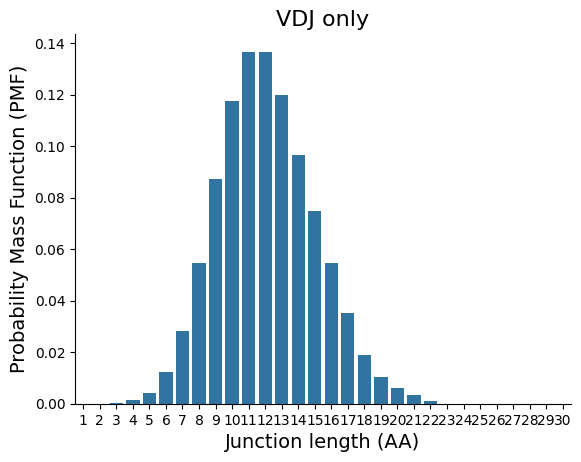

In [24]:
sns.barplot(perlen_pmf, x='total_len', y='pmf_total', )
ax = plt.gca()
ax.spines[['top', 'right']].set_visible(False)
ax.set_title('VDJ only', fontsize=16)
ax.set_xlabel('Junction length (AA)', fontsize=14)
ax.set_ylabel('Probability Mass Function (PMF)', fontsize=14)
plt.savefig('./figS5A.svg', dpi=1200)
plt.show()

In [25]:
df = df.with_columns(
    pl.concat_str([pl.col("junction_n1_aa"), pl.col("junction_n2_aa")], separator="").str.len_chars().alias('length_np_aa')
)

In [26]:
ln = df['length_np_aa'].value_counts(sort=True, parallel=True)[0:20]

In [27]:
ln = ln.fill_null(0)

In [30]:
def per_length_pmf_via_convolution_with_n(i: pl.DataFrame, j: pl.DataFrame, ln: pl.DataFrame, k: pl.DataFrame) -> pd.DataFrame:
    """
    Fast 3-way convolution of PMFs (V, D, J) over amino-acid lengths.
    Returns pandas DataFrame: total_len, pmf_total, mass (scaled by raw totals)
    """
    v = normalize_to_pmf(i, "junction_v_aa", "count").to_pandas()
    d = normalize_to_pmf(k, "junction_germ_d_aa", "count").to_pandas()
    n = normalize_to_pmf(ln, 'length_np_aa', "count").to_pandas()
    j_ = normalize_to_pmf(j, "junction_j_aa", "count").to_pandas()

    v_min, v_max = int(v["junction_v_aa"].min()), int(v["junction_v_aa"].max())
    d_min, d_max = int(d["junction_germ_d_aa"].min()), int(d["junction_germ_d_aa"].max())
    n_min, n_max = int(n["length_np_aa"].min()), int(n["length_np_aa"].max())
    j_min, j_max = int(j_["junction_j_aa"].min()), int(j_["junction_j_aa"].max())

    v_vec = np.zeros(v_max - v_min + 1, dtype=float)
    d_vec = np.zeros(d_max - d_min + 1, dtype=float)
    n_vec = np.zeros(n_max - n_min + 1, dtype=float)
    j_vec = np.zeros(j_max - j_min + 1, dtype=float)

    for L, p in zip(v["junction_v_aa"], v["prob"]): v_vec[int(L) - v_min] = p
    for L, p in zip(d["junction_germ_d_aa"], d["prob"]): d_vec[int(L) - d_min] = p
    for L, p in zip(n["length_np_aa"], d["prob"]): n_vec[int(L) - n_min] = p
    for L, p in zip(j_["junction_j_aa"], j_["prob"]): j_vec[int(L) - j_min] = p

    vd  = np.convolve(v_vec, d_vec)
    vdn  = np.convolve(vd, n_vec)
    vdnj = np.convolve(vdn, j_vec)

    total_min = v_min + d_min + n_min + j_min
    total_max = v_max + d_max + n_max + j_max
    total_lens = np.arange(total_min, total_max + 1, dtype=int)

    # optional: scale PMF by raw totals to get an unnormalized "mass"
    V_tot = i["count"].sum()
    D_tot = k["count"].sum()
    N_tot = ln["count"].sum()
    J_tot = j["count"].sum()
    out = pd.DataFrame({"total_len": total_lens, "pmf_total": vdnj})
    out["mass"] = out["pmf_total"] * (V_tot * D_tot * N_tot * J_tot)
    return out


In [31]:
perlen_pmf_n = per_length_pmf_via_convolution_with_n(i, j, ln, k)

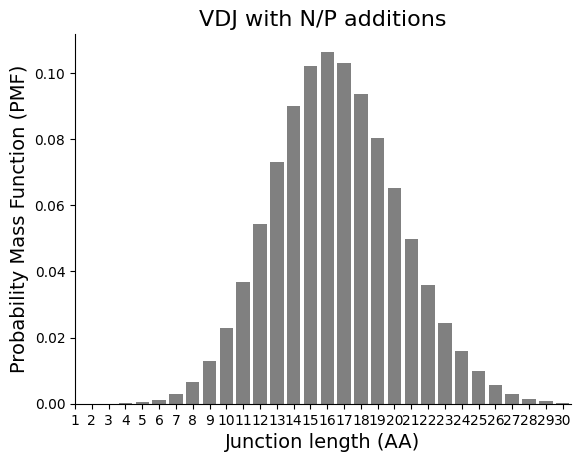

In [32]:
sns.barplot(perlen_pmf_n, x='total_len', y='pmf_total', color='grey')
ax = plt.gca()
ax.spines[['top', 'right']].set_visible(False)
ax.set_title('VDJ with N/P additions', fontsize=16)
ax.set_xlabel('Junction length (AA)', fontsize=14)
ax.set_ylabel('Probability Mass Function (PMF)', fontsize=14)
ax.set_xlim(0,29.5)
plt.savefig('./figS5B.svg', dpi=1200)
plt.show()


In [58]:
import polars as pl
import numpy as np

def print_params(df, x):
    if type(df) == pd.DataFrame:
        df = pl.from_pandas(df)
    
    summ = df.select(
        pl.col(x).mean().alias("mean"),
        pl.col(x).std(ddof=1).alias("sd"),
        pl.col(x).median().alias("median"),
        pl.col(x).quantile(0.25).alias("q1"),
        pl.col(x).quantile(0.75).alias("q3"),
    )
    
    # IQR
    summ = summ.with_columns((pl.col("q3") - pl.col("q1")).alias("IQR"))
    
    # MAD (about the median)
    median_val = df.select(pl.col(x).median()).item()
    mad = (df
           .with_columns((pl.col(x) - median_val).abs().alias("abs_dev"))
           .select(pl.col("abs_dev").median().alias("MAD"))
          ).item()
    
    # (Optional) skewness, kurtosis — Polars helpers:
    shape = df.select(
        pl.col(x).skew().alias("skewness"),
        pl.col(x).kurtosis().alias("kurtosis")
    )

    return summ, median_val, mad, shape


In [59]:
perlen_pmf

,total_len,pmf_total,mass
0,1,9.918677e-06,3771135105460088832.0
1,2,4.964513e-05,18875350417192341504.0
2,3,2.572951e-04,97825016170506616832.0
3,4,1.387557e-03,527556794121233694720.0
4,5,4.344375e-03,1651755000959884328960.0
5,6,1.220389e-02,4639986863529283026944.0
6,7,2.821884e-02,10728956518505849552896.0
7,8,5.449059e-02,20717620124674716336128.0
8,9,8.727093e-02,33180882011791407710208.0
9,10,1.176645e-01,44736675034767619522560.0


In [60]:
print_params(perlen_pmf, 'pmf_total')

(shape: (1, 6)
 ┌──────────┬──────────┬──────────┬──────────┬──────────┬──────────┐
 │ mean     ┆ sd       ┆ median   ┆ q1       ┆ q3       ┆ IQR      │
 │ ---      ┆ ---      ┆ ---      ┆ ---      ┆ ---      ┆ ---      │
 │ f64      ┆ f64      ┆ f64      ┆ f64      ┆ f64      ┆ f64      │
 ╞══════════╪══════════╪══════════╪══════════╪══════════╪══════════╡
 │ 0.033333 ┆ 0.046765 ┆ 0.005312 ┆ 0.000022 ┆ 0.054743 ┆ 0.054721 │
 └──────────┴──────────┴──────────┴──────────┴──────────┴──────────┘,
 0.005312079375990333,
 0.005310778956327134,
 shape: (1, 2)
 ┌──────────┬───────────┐
 │ skewness ┆ kurtosis  │
 │ ---      ┆ ---       │
 │ f64      ┆ f64       │
 ╞══════════╪═══════════╡
 │ 1.160187 ┆ -0.163641 │
 └──────────┴───────────┘)

In [61]:
print_params(perlen_pmf_n, 'pmf_total')

(shape: (1, 6)
 ┌──────┬──────────┬──────────┬───────────┬──────────┬──────────┐
 │ mean ┆ sd       ┆ median   ┆ q1        ┆ q3       ┆ IQR      │
 │ ---  ┆ ---      ┆ ---      ┆ ---       ┆ ---      ┆ ---      │
 │ f64  ┆ f64      ┆ f64      ┆ f64       ┆ f64      ┆ f64      │
 ╞══════╪══════════╪══════════╪═══════════╪══════════╪══════════╡
 │ 0.02 ┆ 0.033545 ┆ 0.000359 ┆ 8.2595e-8 ┆ 0.024493 ┆ 0.024493 │
 └──────┴──────────┴──────────┴───────────┴──────────┴──────────┘,
 0.000358640074051996,
 0.000358640074051996,
 shape: (1, 2)
 ┌──────────┬──────────┐
 │ skewness ┆ kurtosis │
 │ ---      ┆ ---      │
 │ f64      ┆ f64      │
 ╞══════════╪══════════╡
 │ 1.534956 ┆ 0.863476 │
 └──────────┴──────────┘)

In [62]:
print_params(ln, 'length_np_aa')

(shape: (1, 6)
 ┌───────┬──────────┬────────┬─────┬──────┬─────┐
 │ mean  ┆ sd       ┆ median ┆ q1  ┆ q3   ┆ IQR │
 │ ---   ┆ ---      ┆ ---    ┆ --- ┆ ---  ┆ --- │
 │ f64   ┆ f64      ┆ f64    ┆ f64 ┆ f64  ┆ f64 │
 ╞═══════╪══════════╪════════╪═════╪══════╪═════╡
 │ 10.45 ┆ 6.004165 ┆ 10.5   ┆ 6.0 ┆ 15.0 ┆ 9.0 │
 └───────┴──────────┴────────┴─────┴──────┴─────┘,
 10.5,
 5.0,
 shape: (1, 2)
 ┌───────────┬───────────┐
 │ skewness  ┆ kurtosis  │
 │ ---       ┆ ---       │
 │ f64       ┆ f64       │
 ╞═══════════╪═══════════╡
 │ -0.049273 ┆ -1.140174 │
 └───────────┴───────────┘)

In [63]:
import polars as pl
import math

def _weighted_quantiles_polars(df: pl.DataFrame, len_col="total_len", p_col="pmf_total",
                               qs=(0.25, 0.5, 0.75)):
    """
    Compute weighted quantiles from a discrete pmf over `len_col`.
    Returns dict {q: q_value}. Uses a left-closed CDF step function (no interpolation).
    """
    cdf = (df
           .select(len_col, p_col)
           .sort(len_col)
           .with_columns(pl.col(p_col).cumsum().alias("_cdf")))
    out = {}
    for q in qs:
        # first length where CDF >= q
        val = (cdf.filter(pl.col("_cdf") >= q)
                  .select(len_col)
                  .head(1)
                  .item())
        out[q] = float(val)
    return out

def compute_length_metrics_polars(df: pl.DataFrame, len_col="total_len", p_col="pmf_total"):
    """
    Compute entropy, effective #lengths, inverse Simpson, mean/var/sd of total length,
    and weighted Q1/median/Q3/IQR from a per-length pmf table.
    Returns a Polars DataFrame with a single row of metrics.
    """
    # normalize (just in case) and drop zero/NaN
    base = (df.select([
                pl.col(len_col).cast(pl.Float64).alias("L"),
                pl.col(p_col).cast(pl.Float64).alias("p")
            ])
            .filter(pl.col("p").is_finite() & (pl.col("p") > 0))
            )
    # renormalize to sum=1
    total_p = base.select(pl.col("p").sum()).item()
    base = base.with_columns((pl.col("p") / total_p).alias("p"))

    # support size
    support_size = base.height

    # entropy (natural log), effective number of lengths
    # filter p>0 already done
    H = (base.with_columns((-pl.col("p") * pl.col("p").log()).alias("_term"))
              .select(pl.col("_term").sum())
              .item())
    N_eff = math.exp(H)

    # inverse simpson
    inv_simpson = 1.0 / base.select((pl.col("p")**2).sum()).item()

    # mean/var/sd of total length under pmf
    mu = base.select((pl.col("L") * pl.col("p")).sum()).item()
    var = base.select(((pl.col("L") - mu)**2 * pl.col("p")).sum()).item()
    sd = math.sqrt(var)

    # weighted quantiles & IQR
    qvals = _weighted_quantiles_polars(base.rename({"L": len_col, "p": p_col}),
                                       len_col=len_col, p_col=p_col,
                                       qs=(0.25, 0.5, 0.75))
    q1, med, q3 = qvals[0.25], qvals[0.5], qvals[0.75]
    iqr = q3 - q1

    return pl.DataFrame([{
        "support_size": float(support_size),
        "entropy_nats": H,
        "N_eff_expH": N_eff,
        "inv_simpson": inv_simpson,
        "len_mean": mu,
        "len_var": var,
        "len_sd": sd,
        "len_q1": q1,
        "len_median": med,
        "len_q3": q3,
        "len_IQR": iqr,
    }])

def compare_length_metrics_polars(df_a: pl.DataFrame, df_b: pl.DataFrame,
                                  label_a="A", label_b="B",
                                  len_col="total_len", p_col="pmf_total"):
    """
    Side-by-side comparison of the metric table for df_a and df_b, plus deltas (B - A).
    """
    if type(df_a) == pd.DataFrame:
            df_a = pl.from_pandas(df_a)
    if type(df_b) == pd.DataFrame:
            df_b = pl.from_pandas(df_b)
        
    A = compute_length_metrics_polars(df_a, len_col, p_col).with_columns(pl.lit(label_a).alias("model"))
    B = compute_length_metrics_polars(df_b, len_col, p_col).with_columns(pl.lit(label_b).alias("model"))

    # stack and pivot long->wide for a compact comparison
    long = (pl.concat([A, B])
              .melt(id_vars=["model"])
              .rename({"variable": "metric"}))
    wide = (long.pivot(values="value", index="metric", columns="model")
                 .with_columns((pl.col(label_b) - pl.col(label_a)).alias(f"delta_{label_b}_minus_{label_a}"))
                 .sort("metric"))
    return wide


In [64]:
import numpy as np
import pandas as pd

def compute_length_metrics_pd(df: pd.DataFrame, len_col="total_len", p_col="pmf_total"):
    x = df[[len_col, p_col]].dropna().astype({len_col: float, p_col: float})
    x = x[x[p_col] > 0].copy()
    x[p_col] /= x[p_col].sum()

    support_size = len(x)
    p = x[p_col].to_numpy()
    L = x[len_col].to_numpy()

    # entropy (nats) and N_eff
    H = -np.sum(p * np.log(p))
    N_eff = float(np.exp(H))
    inv_simpson = float(1.0 / np.sum(p**2))

    mu = float(np.sum(L * p))
    var = float(np.sum((L - mu)**2 * p))
    sd  = float(np.sqrt(var))

    # weighted quantiles (discrete CDF)
    order = np.argsort(L)
    Ls = L[order]
    cdf = np.cumsum(p[order])
    def wq(q):
        return float(Ls[np.searchsorted(cdf, q, side="left")])
    q1, med, q3 = wq(0.25), wq(0.5), wq(0.75)
    iqr = q3 - q1

    return pd.DataFrame([{
        "support_size": float(support_size),
        "entropy_nats": float(H),
        "N_eff_expH": N_eff,
        "inv_simpson": inv_simpson,
        "len_mean": mu,
        "len_var": var,
        "len_sd": sd,
        "len_q1": q1,
        "len_median": med,
        "len_q3": q3,
        "len_IQR": iqr,
    }])


In [65]:
import math
import polars as pl
import pandas as pd
import numpy as np

def _ensure_polars(df):
    if isinstance(df, pd.DataFrame):
        return pl.from_pandas(df)
    return df

def _weighted_quantiles_polars(df: pl.DataFrame, len_col="total_len", p_col="pmf_total",
                               qs=(0.25, 0.5, 0.75)):
    """
    Weighted quantiles from a discrete pmf over `len_col`.
    Returns dict {q: q_value}. Uses a left-closed CDF step (no interpolation).
    """
    cdf = (
        df.select(len_col, p_col)
          .sort(len_col)
          .with_columns(pl.col(p_col).cum_sum().alias("_cdf"))  # <-- cum_sum() in Polars
    )
    out = {}
    for q in qs:
        val = (
            cdf.filter(pl.col("_cdf") >= q)
               .select(len_col)
               .head(1)
               .item()
        )
        out[q] = float(val)
    return out

def compute_length_metrics_polars(df, len_col="total_len", p_col="pmf_total"):
    """
    Compute entropy, effective #lengths, inverse Simpson, mean/var/sd of total length,
    and weighted Q1/median/Q3/IQR from a per-length pmf table.
    Accepts pandas or polars; returns a Polars DataFrame (1 row).
    """
    df = _ensure_polars(df)

    base = (
        df.select([
            pl.col(len_col).cast(pl.Float64).alias("L"),
            pl.col(p_col).cast(pl.Float64).alias("p")
        ])
        .filter(pl.col("p").is_finite() & (pl.col("p") > 0))
    )
    total_p = base.select(pl.col("p").sum()).item()
    base = base.with_columns((pl.col("p") / total_p).alias("p"))

    support_size = float(base.height)

    H = (
        base.with_columns((-pl.col("p") * pl.col("p").log()).alias("_term"))
            .select(pl.col("_term").sum())
            .item()
    )
    N_eff = math.exp(H)
    inv_simpson = 1.0 / base.select((pl.col("p")**2).sum()).item()

    mu = base.select((pl.col("L") * pl.col("p")).sum()).item()
    var = base.select(((pl.col("L") - mu)**2 * pl.col("p")).sum()).item()
    sd = math.sqrt(var)

    qvals = _weighted_quantiles_polars(
        base.rename({"L": len_col, "p": p_col}),
        len_col=len_col, p_col=p_col, qs=(0.25, 0.5, 0.75)
    )
    q1, med, q3 = qvals[0.25], qvals[0.5], qvals[0.75]
    iqr = q3 - q1

    return pl.DataFrame([{
        "support_size": support_size,
        "entropy_nats": H,
        "N_eff_expH": N_eff,
        "inv_simpson": inv_simpson,
        "len_mean": mu,
        "len_var": var,
        "len_sd": sd,
        "len_q1": q1,
        "len_median": med,
        "len_q3": q3,
        "len_IQR": iqr,
    }])

def compare_length_metrics_polars(df_a, df_b,
                                  label_a="A", label_b="B",
                                  len_col="total_len", p_col="pmf_total"):
    """
    Side-by-side comparison of metrics for df_a and df_b (pandas or polars ok).
    Returns a Polars DataFrame with columns: metric, A, B, delta_B_minus_A.
    """
    df_a = _ensure_polars(df_a)
    df_b = _ensure_polars(df_b)

    A = compute_length_metrics_polars(df_a, len_col, p_col).with_columns(pl.lit(label_a).alias("model"))
    B = compute_length_metrics_polars(df_b, len_col, p_col).with_columns(pl.lit(label_b).alias("model"))

    long = (
        pl.concat([A, B])
          .melt(id_vars=["model"])
          .rename({"variable": "metric"})
    )
    wide = (
        long.pivot(values="value", index="metric", columns="model")
            .with_columns((pl.col(label_b) - pl.col(label_a)).alias(f"delta_{label_b}_minus_{label_a}"))
            .sort("metric")
    )
    return wide


In [66]:
# VDJ only
metrics_vdj = compute_length_metrics_pd(perlen_pmf)
print(metrics_vdj)

# VDJ + N/P
metrics_vdj_np = compute_length_metrics_pd(perlen_pmf_n)
print(metrics_vdj_np)

# Side-by-side with deltas
cmp = compare_length_metrics_polars(perlen_pmf, perlen_pmf_n,
                                    label_a="VDJ", label_b="VDJ+NP")
print(cmp)


   support_size  entropy_nats  N_eff_expH  inv_simpson   len_mean   len_var  \
0          30.0      2.488285   12.040613    10.335258  12.097639  8.631324   

     len_sd  len_q1  len_median  len_q3  len_IQR  
0  2.937912    10.0        12.0    14.0      4.0  
   support_size  entropy_nats  N_eff_expH  inv_simpson   len_mean    len_var  \
0          40.0      2.739937   15.486012     13.30863  16.544109  14.127696   

     len_sd  len_q1  len_median  len_q3  len_IQR  
0  3.758683    14.0        16.0    19.0      5.0  
shape: (11, 4)
┌──────────────┬───────────┬───────────┬────────────────────────┐
│ metric       ┆ VDJ       ┆ VDJ+NP    ┆ delta_VDJ+NP_minus_VDJ │
│ ---          ┆ ---       ┆ ---       ┆ ---                    │
│ str          ┆ f64       ┆ f64       ┆ f64                    │
╞══════════════╪═══════════╪═══════════╪════════════════════════╡
│ N_eff_expH   ┆ 12.040613 ┆ 15.486012 ┆ 3.445399               │
│ entropy_nats ┆ 2.488285  ┆ 2.739937  ┆ 0.251652               │

/tmp/ipykernel_20476/2921261157.py:101: DeprecationWarning: `DataFrame.melt` is deprecated; use `DataFrame.unpivot` instead, with `index` instead of `id_vars` and `on` instead of `value_vars`
  .melt(id_vars=["model"])
/tmp/ipykernel_20476/2921261157.py:105: DeprecationWarning: the argument `columns` for `DataFrame.pivot` is deprecated. It was renamed to `on` in version 1.0.0.
  long.pivot(values="value", index="metric", columns="model")


In [67]:
cmp.write_excel('comparative_metrics_panel.xlsx')

In [40]:
import matplotlib.pyplot as plt

In [68]:
def compute_length_metrics_pd(df: pd.DataFrame, len_col="total_len", p_col="pmf_total"):
    x = df[[len_col, p_col]].dropna().astype({len_col: float, p_col: float})
    x = x[x[p_col] > 0].copy()
    x[p_col] /= x[p_col].sum()

    L = x[len_col].to_numpy()
    p = x[p_col].to_numpy()

    H = float(-np.sum(p * np.log(p)))
    N_eff = float(np.exp(H))
    inv_simpson = float(1.0 / np.sum(p**2))

    mu = float(np.sum(L * p))
    var = float(np.sum((L - mu)**2 * p))
    sd  = float(np.sqrt(var))

    order = np.argsort(L); Ls = L[order]; cdf = np.cumsum(p[order])
    def wq(q): return float(Ls[np.searchsorted(cdf, q, side="left")])
    q1, med, q3 = wq(0.25), wq(0.5), wq(0.75)
    iqr = q3 - q1

    return pd.DataFrame([{
        "support_size": float(len(x)),
        "entropy_nats": H,
        "N_eff": N_eff,
        "inv_simpson": inv_simpson,
        "mean": mu,
        "sd": sd,
        "IQR": iqr,
        "q1": q1,
        "median": med,
        "q3": q3
    }])

def plot_pmf_overlay(perlen_pmf, perlen_pmf_n, save_path=None):
    plt.figure()
    plt.plot(perlen_pmf["total_len"], perlen_pmf["pmf_total"], marker="o", label="VDJ", color='blue')
    plt.plot(perlen_pmf_n["total_len"], perlen_pmf_n["pmf_total"], marker="s", label="VDJ+NP", color='black')
    plt.title("Probability mass function (PMF)\nover total junction length (AA)")
    plt.xlabel("Total length (AA)")
    plt.ylabel("PMF")
    ax = plt.gca()
    ax.spines[['top','right']].set_visible(False)
    plt.legend()
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=200, bbox_inches="tight")
    plt.show()

def plot_metrics_panel(metrics_panel, panel_metrics=None, save_path=None):
    if panel_metrics is None:
        panel_metrics = ["entropy_nats", "N_eff", "inv_simpson", "mean", "sd", "IQR"]
    long = metrics_panel.melt(id_vars=["model"], 
                              value_vars=panel_metrics,
                              variable_name="metric", 
                              value_name="value")
    metrics = panel_metrics
    x = np.arange(len(metrics))
    width = 0.35
    vals_vdj   = [float(long[(long["metric"]==m) & (long["model"]=="VDJ")]["value"]) for m in metrics]
    vals_vdjnp = [float(long[(long["metric"]==m) & (long["model"]=="VDJ+NP")]["value"]) for m in metrics]

    plt.figure()
    plt.bar(x - width/2, vals_vdj, width, label="VDJ")
    plt.bar(x + width/2, vals_vdjnp, width, label="VDJ+NP")
    plt.xticks(x, metrics, rotation=30, ha="right")
    plt.title("Length-PMF metrics side-by-side")
    plt.ylabel("Value")
    ax = plt.gca()
    ax.spines[['top','right']].set_visible(False)
    plt.legend()
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=1200, bbox_inches="tight")
    plt.show()


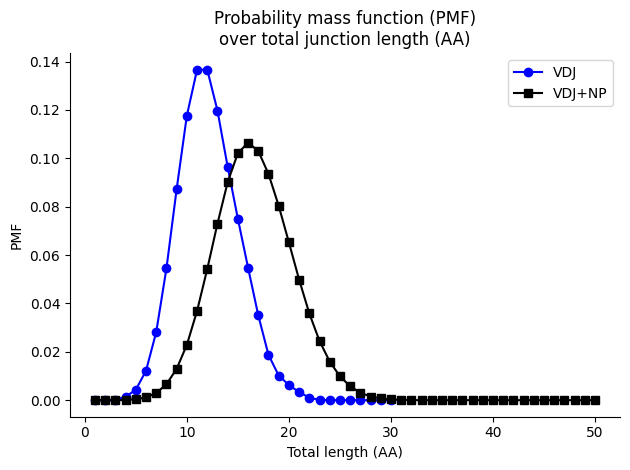

In [69]:
plot_pmf_overlay(perlen_pmf, perlen_pmf_n, save_path='./figS5C.svg')

In [70]:
cmp

metric,VDJ,VDJ+NP,delta_VDJ+NP_minus_VDJ
str,f64,f64,f64
"""N_eff_expH""",12.040613,15.486012,3.445399
"""entropy_nats""",2.488285,2.739937,0.251652
"""inv_simpson""",10.335258,13.30863,2.973372
"""len_IQR""",4.0,5.0,1.0
"""len_mean""",12.097639,16.544109,4.446469
…,…,…,…
"""len_q1""",10.0,14.0,4.0
"""len_q3""",14.0,19.0,5.0
"""len_sd""",2.937912,3.758683,0.820771


In [71]:
def plot_metrics_panel(df, want_metrics=None, save_path=None, title="Length-PMF metrics side-by-side"):
    """
    Works with EITHER:
      - wide compare table from compare_length_metrics_polars: columns ['metric','VDJ','VDJ+NP', 'delta_...']
      - long metrics_panel: columns ['model', 'entropy_nats','N_eff' or 'N_eff_expH','inv_simpson','mean' or 'len_mean', ...]
    Auto-maps aliases and skips missing metrics gracefully.
    """
    import numpy as np, pandas as pd, matplotlib.pyplot as plt
    try:
        import polars as pl
        if isinstance(df, pl.DataFrame):
            df = df.to_pandas()
    except Exception:
        pass

    # what the caller *wants* to see; names are canonical
    if want_metrics is None:
        want_metrics = ["Entropy (nats)", "N (effective)", "inv_simpson", "Mean", "SD", "IQR"]

    # map canonical -> possible column/row names in your data
    aliases = {
        "N (effective)":      ["N_eff", "N_eff_expH"],
        "Mean":       ["mean", "len_mean"],
        "SD":         ["sd", "len_sd"],
        "IQR":        ["IQR", "len_IQR"],
        "Entropy (nats)": ["entropy_nats"],
        "inv_simpson":  ["inv_simpson"],
    }

    # Build a long DataFrame with columns: metric, model, value
    long = None

    col_dict = {'VDJ+NP':'grey','VDJ':'#0077b6'}
    
    if "model" in df.columns:
        # LONG form: melt (pandas) on whichever alias column exists
        rows = []
        for m in ["VDJ", "VDJ+NP"]:
            if m not in df.get("model", []).tolist():
                continue
            sub = df[df["model"] == m]
            for canon in want_metrics:
                # find the first alias present as a column
                col = next((a for a in aliases[canon] if a in sub.columns), None)
                if col is None:
                    continue
                rows.append({"metric": canon, "model": m, "value": float(sub.iloc[0][col])})
        long = pd.DataFrame(rows)

    elif "metric" in df.columns:
        # WIDE form: rows are metrics; columns are models (VDJ, VDJ+NP)
        # create a mapping from actual metric names to canonical names
        name_map = {}
        have = set(df["metric"].astype(str).tolist())
        for canon in want_metrics:
            for a in aliases[canon]:
                if a in have:
                    name_map[a] = canon
                    break
        # filter to the metrics we can map
        keep = df["metric"].astype(str).isin(name_map.keys())
        _df = df.loc[keep].copy()
        if _df.empty:
            raise ValueError("None of the requested metrics are present in the 'metric' column.")

        _df["metric"] = _df["metric"].astype(str).map(name_map)

        # stack into long form on model columns (anything not metric or delta_)
        model_cols = [c for c in _df.columns if c != "metric" and not str(c).startswith("delta_")]
        long = _df.melt(id_vars=["metric"], value_vars=model_cols,
                        var_name="model", value_name="value")

    else:
        raise ValueError("Input must have either a 'model' column (long) or a 'metric' column (wide).")

    # guard: if something is still missing, drop it
    long = long.dropna(subset=["value"])
    # enforce order and only keep requested metrics that we actually have
    long["metric"] = pd.Categorical(long["metric"], categories=want_metrics, ordered=True)
    long = long.sort_values(["metric", "model"])
    present_metrics = [m for m in want_metrics if m in long["metric"].cat.categories and (long["metric"] == m).any()]
    if not present_metrics:
        raise ValueError("No requested metrics found after alias mapping.")

    # group-bar plot
    x = np.arange(len(present_metrics))
    models = sorted(long["model"].unique().tolist())
    width = 0.8 / max(1, len(models))

    plt.figure()
    for i, mod in enumerate(models):
        vals = []
        for met in present_metrics:
            sub = long[(long["metric"] == met) & (long["model"] == mod)]
            vals.append(float(sub["value"].iloc[0]) if not sub.empty else np.nan)
        plt.bar(x + (i - (len(models)-1)/2)*width, vals, width, label=mod, color=col_dict[mod])
    plt.xticks(x, present_metrics, rotation=30, ha="right")
    # plt.title(title)
    plt.ylabel("Value")
    ax = plt.gca()
    ax.spines[['top','right']].set_visible(False)
    plt.legend()
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=1200, bbox_inches="tight")
    plt.show()


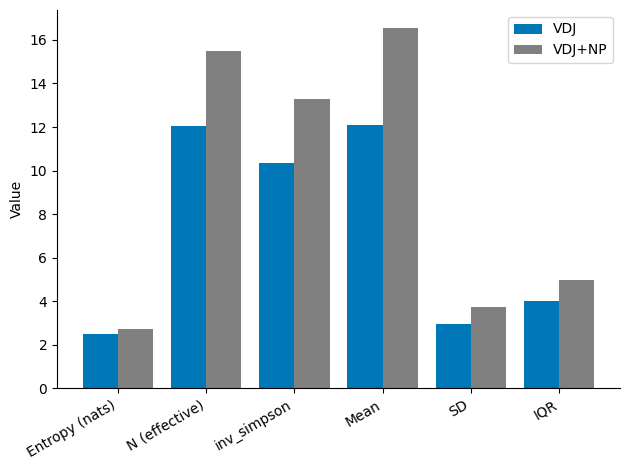

In [72]:
plot_metrics_panel(cmp, save_path='./figS5D.svg')

In [143]:
# pseudo: generator() yields (V, J, CDR3aa, L)
from collections import defaultdict
import random

def estimate_G2_by_length(generator, N=2_000_000, seed=0):
    random.seed(seed)
    buckets = defaultdict(int)
    counts  = defaultdict(int)
    for _ in range(N):
        V,J,aa,L = generator()
        key = (V,J,aa)  # exact clonotype
        buckets[(L, key)] += 1
        counts[L] += 1
    G2 = {}
    for L, cL in counts.items():
        # coincidence = sum p^2 = sum (n_i/N_L)^2 over clones in length L
        s = 0.0
        for (l,key), n in buckets.items():
            if l==L:
                p = n / cL
                s += p*p
        G2[L] = s
    return G2


In [ ]:
G2s = {}
for generator in [vdj_only, vdj_np]:
    G2s[generator] = estimate_G2_by_length(generator, )